In [1]:
from dotenv import load_dotenv
from rich import print

load_dotenv()
%load_ext rich
%load_ext autoreload
%autoreload 2

## LangGraph

In [2]:
from textwrap import dedent
from typing import Annotated, Any, Dict, List, Optional

from langchain.pydantic_v1 import BaseModel, Field
from langchain_core.messages import AnyMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import END, MessageGraph, StateGraph, add_messages
from typing_extensions import TypedDict

In [3]:
from youtube_lesson_planner.nodes import generate_plan, planner
from youtube_lesson_planner.tools import get_transcripts, query_rewriter, search_videos


In [4]:
class State(TypedDict):
    query: str
    plan: planner.PlanningTemplate
    step_results: dict
    lesson_plan: generate_plan.LessonPlan


In [5]:
def plan(state: State):
    return planner.get_plan(state['query'])

In [6]:
def generate(state: State):
    return generate_plan.generate_plan(state['query'])

In [7]:
def _get_current_task(state: State):
    if state["step_results"] is None:
        return 1
    if len(state["step_results"]) == len(state["plan"].steps):
        return None
    else:
        return len(state["step_results"]) + 1

In [16]:
def execute_tool(state: State) -> State:
    _step = _get_current_task(state)

    step_details = state["plan"].steps[_step - 1]

    print(f"Executing step {_step}: {step_details.action} - {step_details.tool}")

    _results = state["step_results"] or {}

    if step_details.tool == "query_rewrite":
        result = query_rewriter.query_rewrite(state["query"], state["plan"])
        result = result.optimized_query

    elif step_details.tool == "search_videos":
        result = search_videos.search_youtube_videos(state["step_results"][1], max_results=10)

    elif step_details.tool == "get_transcripts":
        result = get_transcripts.get_transcripts(state["step_results"][2])

    else:
        result = None

    _results[_step] = result

    return {
        "step_results": _results,
    }

In [17]:
def router(state: State):
    _step = _get_current_task(state)

    if _step is None:
        return "generate"

    else:
        return "execute"


In [18]:
workflow = StateGraph(State)

workflow.add_node("planner", plan)
workflow.add_node("generator", generate)
workflow.add_node("execute", execute_tool)

workflow.add_edge("planner", "execute")
workflow.add_conditional_edges(
    "execute", router, {"execute": "execute", "generate": "generator"}
)
workflow.add_edge("generator", END)

workflow.set_entry_point("planner")

graph = workflow.compile()

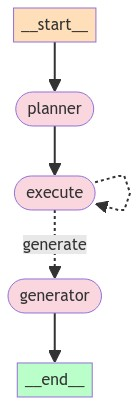

In [19]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())


In [26]:
response = graph.invoke({"query": "survive on a stranded boat in ocean"})

Executing step 1: Rewrite the user's query to optimize it for YouTube. - query_rewrite

Executing step 2: Search for videos using the optimized query. - search_videos

Executing step 3: Get the transcripts of the videos to understand their content in detail. - get_transcripts

In [27]:
response['lesson_plan']


LessonPlan(
    title='Surviving on a Stranded Boat in the Ocean',
    description='This curriculum is designed to equip you with the essential knowledge and skills needed to survive if you ever find yourself stranded on a boat in the middle of the ocean. Drawing from real-life stories and expert advice, this course will cover finding water, securing food, staying mentally strong, and signaling for rescue.',
    videos=[
        Video(
            title='How to Survive Being Stranded on a Deserted Island, According to Science',
            url='https://www.youtube.com/watch?v=opdtSxvwjoE&t=30s',
            transcript="How do you endure being stranded on a deserted island? Well, here's how you survive, Hey, don't try to wing it. You'd be best to borrow a tip from the Boy Scouts. They use the acronym S.T.O.P. It stands for: Stop, Think, Observe and Plan. Since people can't survive without water for more than 3-4 days, your first and biggest priority would be to find a water source."
  